In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, GradientDescent, SPSA, SLSQP 
from qiskit.quantum_info import state_fidelity
from qiskit.circuit.library import EfficientSU2

/tmp/ipykernel_545/1361051065.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, GradientDescent, SPSA, SLSQP


In [2]:
# Create Single 3 Qubit variational form given a QuantumCircuit
def add_var_form(qc, current_rep, params):
  num_qubits = len(qc.qubits)
  for current_qubit_index in range(num_qubits):
    qc.rx(params[2*(current_qubit_index) + 6*current_rep], current_qubit_index)
    qc.rz(params[2*(current_qubit_index) + 6*current_rep + 1], current_qubit_index)

# Create the entire variational form circuit with repetitions
## Returns a quantumcircuit
## params[rep][0-5 for each single qubit gate]
def create_var_form_circuit(num_qubits, num_cbits, num_reps, params):
  qc = QuantumCircuit(num_qubits, num_cbits)
  for current_rep in range(num_reps):
    add_var_form(qc, current_rep, params)
  qc.measure_all(add_bits=False)
  return qc

In [3]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 1000

# Initialise COBYLA
optimizer = COBYLA(maxiter=10, tol=0.000001)
#optimizer  = GradientDescent(maxiter=10)

num_qbits = 4
num_reps   = 1
num_1qg    = 2 #number of 1 qubit gates per qubit per rep
num_cbits  = num_qbits

params = np.random.rand(num_reps*num_1qg*num_qbits)

basis_states = [format(current_value, '0'+str(num_qbits)+'b') for current_value in range(0,2**num_qbits)]
use_qiskit_function_flag = True

In [4]:
# Given the set of counts measured for each basis state return a vector of probabilities
def get_probability_distribution(counts):
  output_dist = []
  for current_key in basis_states:
    output_dist.append(counts.get(current_key, 0)/NUM_SHOTS)
  if (len(output_dist) == 1):
    output_dist.append(1 - output_dist[0])
  return output_dist

def objective_function(params):
  if use_qiskit_function_flag:
    #Qiskit built in function
    qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
    qc = qc.assign_parameters(params)

    qc.measure_all()
  else:
    #Manually create variational form
    qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, params)
  #Execute the quantum circuit to obtain the probability distribution associated with the current parameters
  trans_qc = transpile(qc, backend)
  qobj     = assemble(trans_qc, shots=NUM_SHOTS)
  result = backend.run(trans_qc, shots=NUM_SHOTS).result()
  #result   = backend.run(qobj, shots=NUM_SHOTS).result()
  #Obtain the counts for each measured state, and convert those counts into a probability vector
  output_dist  = get_probability_distribution(result.get_counts(qc))
  #Then create a valid quantum state vector
  output_state = output_dist/(np.sqrt(sum(np.abs(output_dist)**2)))
  #Calculate the cost using state fidelity
  #cost = sum([np.abs(output_state[i] - target_dist[i]) for i in range(len(target_dist))])
  cost = state_fidelity(Statevector(target_state), Statevector(output_state))
  return (1-cost)

## Question 1

In [5]:
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Statevector(target_state).draw('latex')


<IPython.core.display.Latex object>

Variational Form Linear 0.1

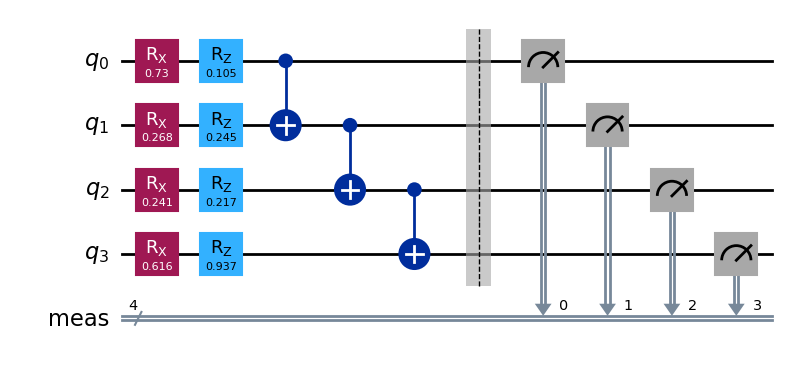

In [6]:
qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
qc = qc.assign_parameters(params)
qc.measure_all()
qc.decompose().draw('mpl', fold=-1, style='iqp')

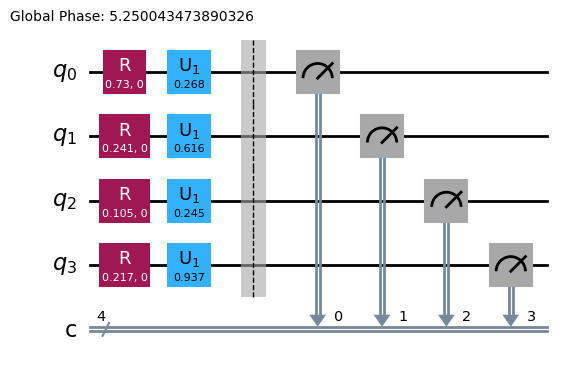

In [7]:
qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, params)
qc.decompose().draw('mpl', fold=-1, style='iqp')

In [8]:
num_qbits = 4
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])

num_cbits  = num_qbits
num_reps = 1
params = np.random.rand(num_reps*num_1qg*num_qbits)

basis_states = [format(current_value, '0'+str(num_qbits)+'b') for current_value in range(0,2**num_qbits)]
use_qiskit_function_flag = True

Statevector(target_state).draw('latex')


<IPython.core.display.Latex object>

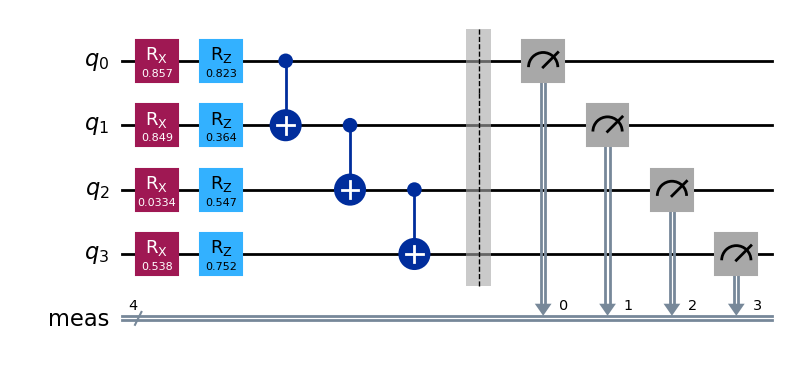

In [9]:
qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
qc = qc.assign_parameters(params)
qc.measure_all()
qc.decompose().draw('mpl', fold=-1, style='iqp')

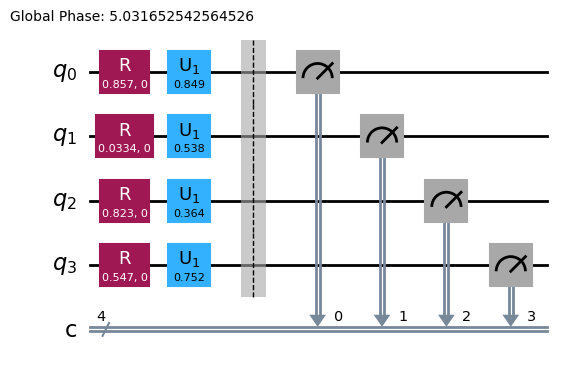

In [10]:
qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, params)
qc.decompose().draw('mpl', fold=-1, style='iqp')

1b) COYBLA Optimizer linear 4 graphs state by state

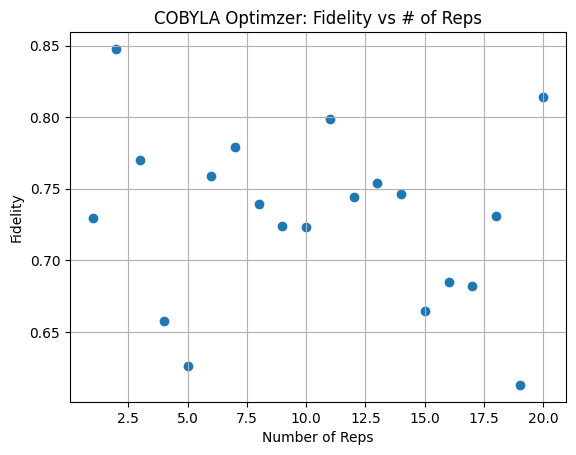

In [11]:
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

x = np.arange(1, 21, 1)
y = []

#Obtain optimized circuit
for i in range(len(x)):
  num_reps = x[i]
  params     = np.random.rand(num_reps*num_1qg*num_qbits)
  result_op  = optimizer.minimize(fun = objective_function, x0 = params)
  
  qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
  qc = qc.assign_parameters(result_op.x)
  qc.measure_all()

  trans_qc     = transpile(qc, backend)
  qobj         = assemble(trans_qc, shots=1000)
  counts       = backend.run(trans_qc).result().get_counts()
  output_dist  = get_probability_distribution(counts)
  output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

  y.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

plt.scatter(x, y)
plt.title("COBYLA Optimzer: Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Fidelity")
plt.grid()

plt.show()


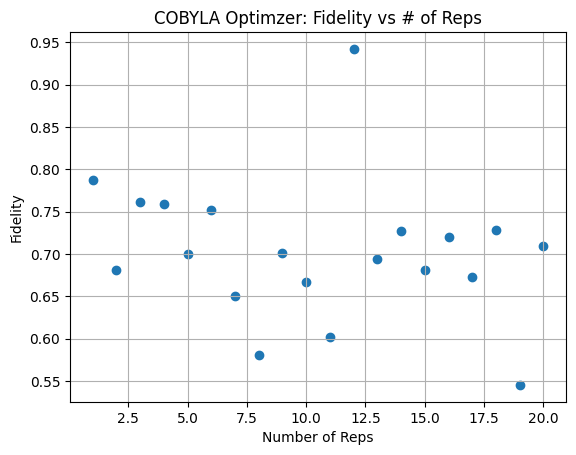

In [12]:
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
use_qiskit_function_flag = False

x = np.arange(1, 21, 1)
y = []

#Obtain optimized circuit
for i in range(len(x)):
  num_reps = x[i]
  params     = np.random.rand(num_reps*num_1qg*num_qbits)
  result_op  = optimizer.minimize(fun = objective_function, x0 = params)
  
  qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, result_op.x)

  trans_qc     = transpile(qc, backend)
  qobj         = assemble(trans_qc, shots=1000)
  counts       = backend.run(trans_qc).result().get_counts()
  output_dist  = get_probability_distribution(counts)
  output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

  y.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

plt.scatter(x, y)
plt.title("COBYLA Optimzer: Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Fidelity")
plt.grid()

plt.show()


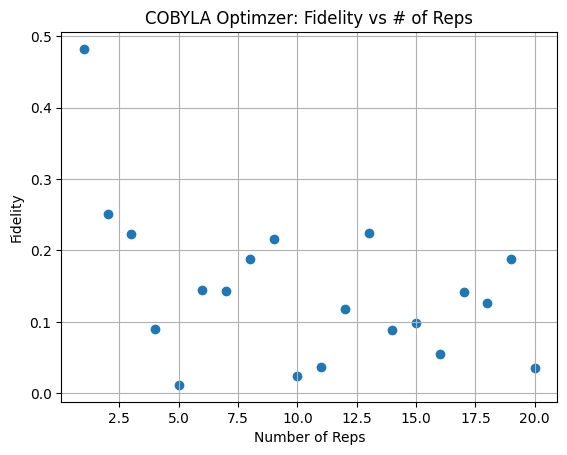

In [13]:
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])
use_qiskit_function_flag = True

x = np.arange(1, 21, 1)
y = []

#Obtain optimized circuit
for i in range(len(x)):
  num_reps = x[i]
  params     = np.random.rand(num_reps*num_1qg*num_qbits)
  result_op  = optimizer.minimize(fun = objective_function, x0 = params)
  
  qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
  qc = qc.assign_parameters(result_op.x)
  qc.measure_all()

  trans_qc     = transpile(qc, backend)
  qobj         = assemble(trans_qc, shots=1000)
  counts       = backend.run(trans_qc).result().get_counts()
  output_dist  = get_probability_distribution(counts)
  output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

  y.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

plt.scatter(x, y)
plt.title("COBYLA Optimzer: Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Fidelity")
plt.grid()

plt.show()

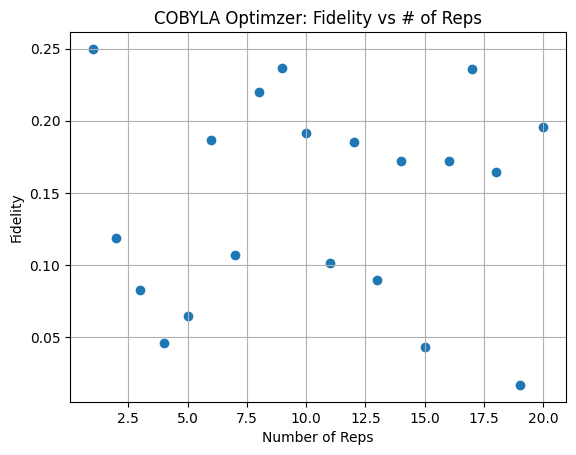

In [14]:
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])
use_qiskit_function_flag = False

x = np.arange(1, 21, 1)
y = []

#Obtain optimized circuit
for i in range(len(x)):
  num_reps = x[i]
  params     = np.random.rand(num_reps*num_1qg*num_qbits)
  result_op  = optimizer.minimize(fun = objective_function, x0 = params)
  
  qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, result_op.x)

  trans_qc     = transpile(qc, backend)
  qobj         = assemble(trans_qc, shots=1000)
  counts       = backend.run(trans_qc).result().get_counts()
  output_dist  = get_probability_distribution(counts)
  output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

  y.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

plt.scatter(x, y)
plt.title("COBYLA Optimzer: Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Fidelity")
plt.grid()

plt.show()


1d) Average of fidelities

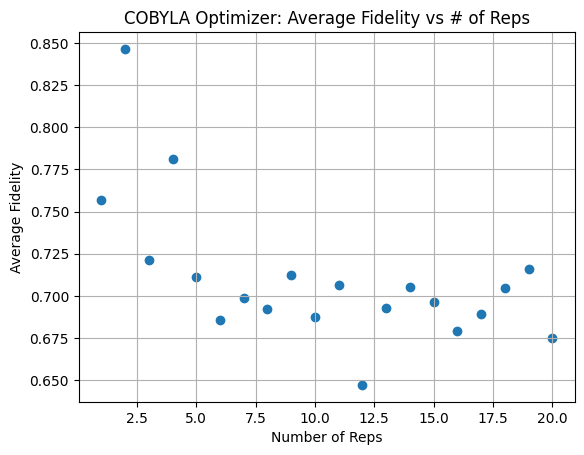

In [15]:
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
use_qiskit_function_flag = True

# Vary the number of repetitions
num_reps_range = np.arange(1, 21, 1)
avg_fidelities = []

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)
        optimizer = COBYLA(maxiter=10, tol=0.000001)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("COBYLA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


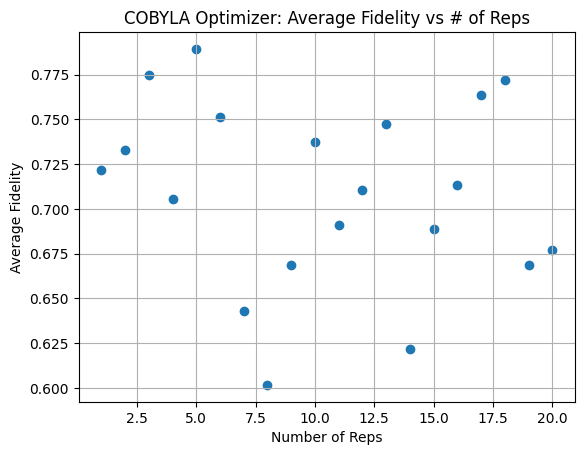

In [16]:
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
use_qiskit_function_flag = False

# Vary the number of repetitions
num_reps_range = np.arange(1, 21, 1)
avg_fidelities = []

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    
    fidelities = []

    for _ in range(num_runs):
        num_reps = x[i]
        params     = np.random.rand(num_reps*num_1qg*num_qbits)
        result_op  = optimizer.minimize(fun = objective_function, x0 = params)
        
        qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, result_op.x)

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("COBYLA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


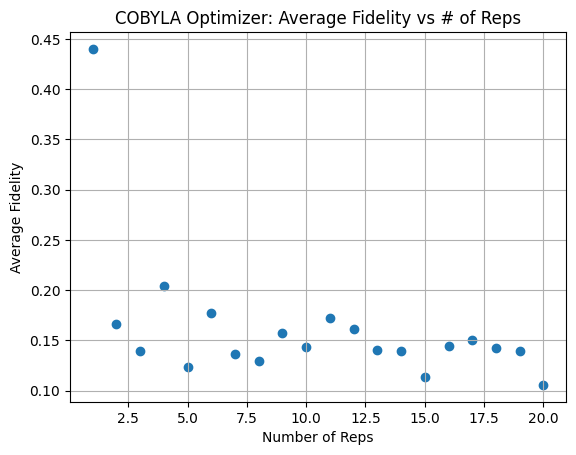

In [17]:
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])
use_qiskit_function_flag = True

# Vary the number of repetitions
num_reps_range = np.arange(1, 21, 1)
avg_fidelities = []

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)
        optimizer = COBYLA(maxiter=10, tol=0.000001)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("COBYLA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


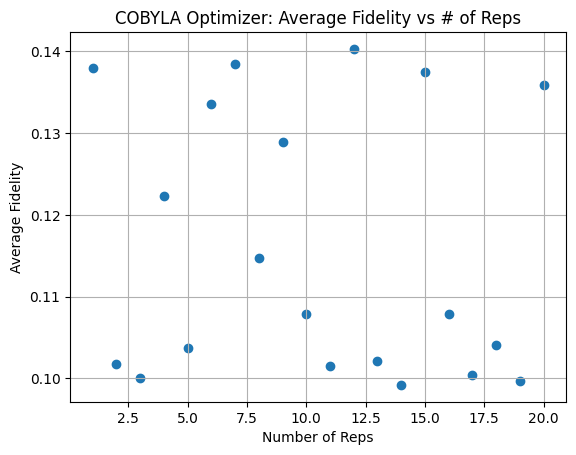

In [18]:
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])
use_qiskit_function_flag = False

# Vary the number of repetitions
num_reps_range = np.arange(1, 21, 1)
avg_fidelities = []

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    
    fidelities = []

    for _ in range(num_runs):
        num_reps = x[i]
        params     = np.random.rand(num_reps*num_1qg*num_qbits)
        result_op  = optimizer.minimize(fun = objective_function, x0 = params)
        
        qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, result_op.x)

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("COBYLA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


Invetigating Optimzers

#Now choose one of the 4 combinations from above with a fixed number of repetitions and investigate
the following:
(a) How does the choice of classical optimizer affect the fidelity? Compare your choice of 3 classical
optimizers provided within Qiskit. Plot your results.
(b) How does the number of shots affect the fidelity? You need not consider more than 10,000 shots.
Plot your results

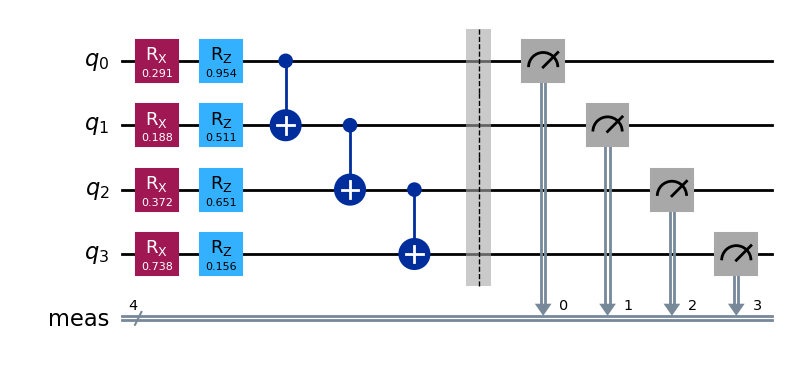

In [19]:
num_reps = 1
params = np.random.rand(num_reps * num_1qg * num_qbits)
target_state = (1/4)*np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
qc = qc.assign_parameters(params)
qc.measure_all()
qc.decompose().draw('mpl', fold=-1, style='iqp')

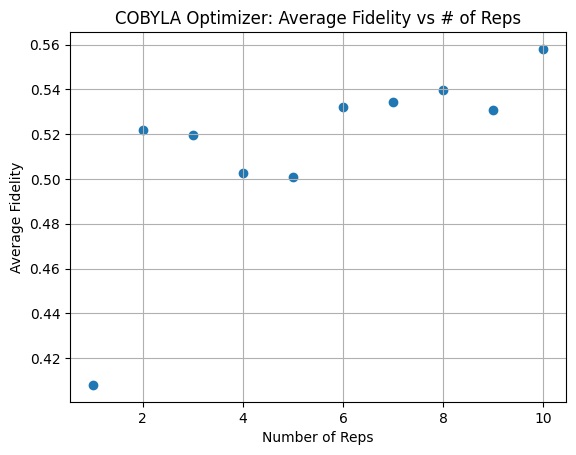

In [20]:
# Vary the number of repetitions
num_reps_range = np.arange(1, 11, 1)
avg_fidelities = []
optimizer = COBYLA(maxiter=10, tol=0.000001)

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("COBYLA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


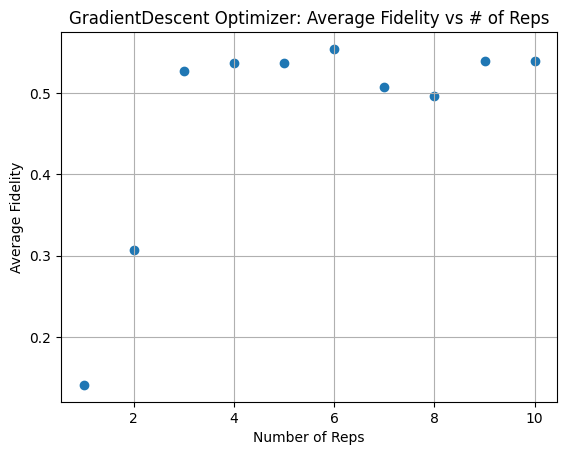

In [21]:
# Vary the number of repetitions
num_reps_range = np.arange(1, 11, 1)
avg_fidelities = []
optimizer = GradientDescent(maxiter=10, tol=0.000001)

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("GradientDescent Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


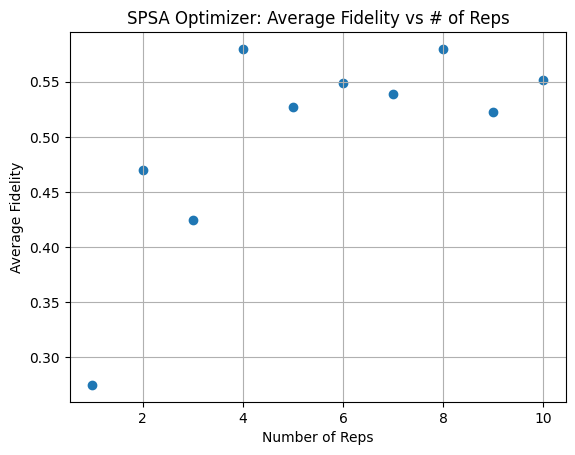

In [22]:
# Vary the number of repetitions
num_reps_range = np.arange(1, 11, 1)
avg_fidelities = []
optimizer = SPSA(maxiter=10)

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("SPSA Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


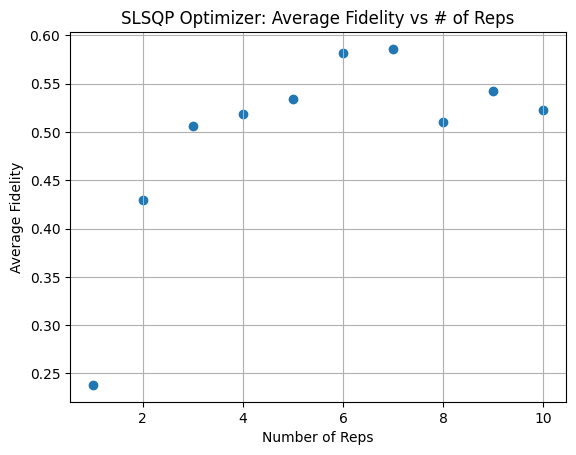

In [23]:
# Vary the number of repetitions
num_reps_range = np.arange(1, 11, 1)
avg_fidelities = []
optimizer = SLSQP(maxiter=10, tol=0.000001)

for num_reps in num_reps_range:
    num_runs = 10  # Number of optimizer runs
    fidelities = []

    for _ in range(num_runs):
        # Initialize random parameters
        params = np.random.rand(num_reps * num_1qg * num_qbits)

        # Optimize the circuit
        result_op = optimizer.minimize(fun=objective_function, x0=params)

        qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
        qc = qc.assign_parameters(result_op.x)
        qc.measure_all()

        trans_qc     = transpile(qc, backend)
        qobj         = assemble(trans_qc, shots=1000)
        counts       = backend.run(trans_qc).result().get_counts()
        output_dist  = get_probability_distribution(counts)
        output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

        fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

    # Average fidelity over runs
    avg_fidelity = np.mean(fidelities)
    avg_fidelities.append(avg_fidelity)

# Plot the results
plt.scatter(num_reps_range, avg_fidelities)
plt.title("SLSQP Optimizer: Average Fidelity vs # of Reps")
plt.xlabel("Number of Reps")
plt.ylabel("Average Fidelity")
plt.grid()
plt.show()


Num of Shots Investigation

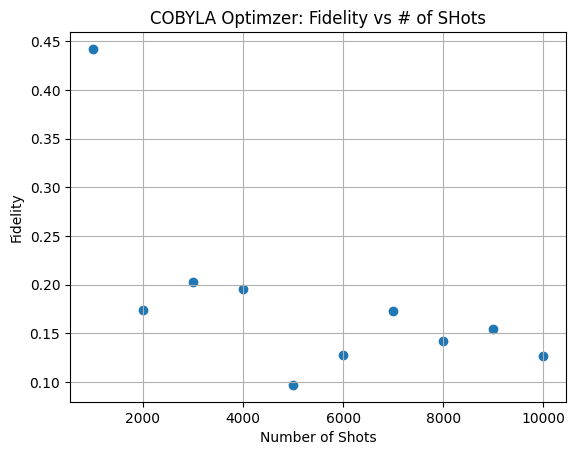

In [24]:
target_state = (1/2)*np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1])
use_qiskit_function_flag = True
x = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
optimizer = COBYLA(maxiter=10, tol=0.000001)

avg_fidelities = []
for num_reps in num_reps_range:
  num_runs = 10  # Number of optimizer runs
  fidelities = []

  #Obtain optimized circuit
  for i in range(len(x)):
    NUM_SHOTS = x[i]
    params     = np.random.rand(num_reps*num_1qg*num_qbits)
    result_op  = optimizer.minimize(fun = objective_function, x0 = params)
    
    qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
    qc = qc.assign_parameters(result_op.x)
    qc.measure_all()

    trans_qc     = transpile(qc, backend)
    qobj         = assemble(trans_qc, shots=1000)
    counts       = backend.run(trans_qc).result().get_counts()
    output_dist  = get_probability_distribution(counts)
    output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

    fidelities.append(state_fidelity(Statevector(target_state), Statevector(output_state)))

  # Average fidelity over runs
  avg_fidelity = np.mean(fidelities)
  avg_fidelities.append(avg_fidelity)

plt.scatter(x, avg_fidelities)
plt.title("COBYLA Optimzer: Fidelity vs # of SHots")
plt.xlabel("Number of Shots")
plt.ylabel("Fidelity")
plt.grid()
plt.show()

NUM_SHOTS = 1000